In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#EVALUATE GOOGLENET MODEL AND GENERATE GRAPHS

from tensorflow import keras
from keras.layers import Activation
from keras.utils import get_custom_objects
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the Swish activation function
def swish(x):
    return K.sigmoid(x) * x

# Register the Swish function as a custom activation function
get_custom_objects().update({'swish': Activation(swish),'Activation': Activation})

def evaluate_googlenet_models(models, test_generators):
    num_models = len(models)

    # Loop through each model and corresponding test generator
    for i in range(num_models):
        model = models[i]
        test_generator = test_generators[i]
        print("model.output_shape[-1]  ",model.output_shape[-1])

        # Generate predictions for the test set
        if model.output_shape[-1] == 1:
          # Binary classification with single neuron in last layer
          if isinstance(model.input, list):
            predictions = model.predict([test_generator[0],test_generator[1]], verbose=1)
          else:
            predictions = model.predict(test_generator, verbose=1)
          y_pred = predictions.ravel() > 0.5
        elif model.output_shape[-1] == 2:
          # Binary classification with two neurons in last layer
          predictions = model.predict(test_generator, verbose=1)
          y_pred = np.argmax(predictions, axis=1)
          y_prob = predictions[:, 1] # Use probabilities for positive class
        else:
          # Multi-class classification
          if isinstance(model.input, list):
            predictions = model.predict(test_generator, verbose=1)
          else:
            print('hooo')
            #test_steps_per_epoch = numpy.math.ceil(test_batches.samples / test_batches.batch_size)
            predictions = model.predict_generator(test_generator,test_generator.n // test_generator.batch_size+1, verbose=1)[0]
          y_pred = np.argmax(predictions, axis=1)
          y_prob = predictions

        # Convert the one-hot encoded labels to integers
        y_true = test_generator.classes

        # Calculate various metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')

        # Print the metrics
        print(f"\n\nModel {i+1} Metrics")
        print('Accuracy: {:.4f}'.format(accuracy))
        print('Precision: {:.4f}'.format(precision))
        print('Recall: {:.4f}'.format(recall))
        print('F1-score: {:.4f}'.format(f1))


        # Get the class indices from the test generator
        class_indices = test_generator.class_indices

        # Invert the class indices to get the class labels with sequence
        class_labels = dict((v, k) for k, v in class_indices.items())

        # Map the integer labels to their corresponding class labels
        y_true_labels = [class_labels[label] for label in y_true]
        y_pred_labels = [class_labels[label] for label in y_pred]


        # Print confusion matrix
        cm = confusion_matrix(y_true_labels, y_pred_labels, labels=list(class_labels.values()))
        print('Confusion matrix:\n', cm)

        # Plot confusion matrix with actual labels
        sns.set(font_scale=1.4)
        plt.figure(figsize=(8, 8))
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, square=True, xticklabels=class_labels.values(), yticklabels=class_labels.values())
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

        #bar graph
        metrics_dict={
            'Accuracy':accuracy,
            'Precision':precision,
            'Recall':recall,
            'F1-Score':f1

        }

        plt.bar(metrics_dict.keys(),metrics_dict.values())
        plt.title('Metrics')
        plt.show()

        if model.output_shape[-1] == 1 or model.output_shape[-1] == 2:
            # Binary classification with one or two neurons in last layer
            tn, fp, fn, tp = cm.ravel()
            fpr, tpr, thresholds = roc_curve(y_true, y_prob)
            roc_auc = auc(fpr, tpr)
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver operating characteristic')
            plt.legend(loc="lower right")
            plt.show()

            # Print ROC curve with class labels
            print("ROC Curve with class labels:")
            for i in range(len(fpr)):
                print("{} {}: {:.2f}".format(y_true_labels[i], class_labels[1], fpr[i]))

        if model.output_shape[-1] != 1 and model.output_shape[-1] != 2:
            # Calculate ROC curve and AUC for multi-class classification
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            n_classes = model.output_shape[-1][1]

            for j in range(n_classes):
                fpr[j], tpr[j], _ = roc_curve(y_true == j, y_prob[:, j])
                roc_auc[j] = auc(fpr[j], tpr[j])

            # Plot ROC curve
            sns.set(font_scale=1.4)
            plt.figure(figsize=(8, 8))
            for j in range(n_classes):
                plt.plot(fpr[j], tpr[j], label='ROC curve for {} (area = {:.2f})'.format(class_labels[j], roc_auc[j]), linewidth=2)
            plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic')
            plt.legend(loc="lower right")
            plt.show()

            # Print ROC curve with class labels
            print("ROC Curve with class labels:")
            for j in range(n_classes):
                for i in range(len(fpr[j])):
                    print("{} {}: {:.2f}".format(class_labels[j], y_true_labels[i], fpr[j][i]))




In [ ]:

import cv2
import numpy as np
import os
from keras import backend as K
import keras
from keras.callbacks import LearningRateScheduler
from keras.metrics import categorical_crossentropy
from keras.layers import Activation
from keras.utils import get_custom_objects

import matplotlib.pyplot as plt
import os
import shutil
import random
import glob
import math
import tensorflow as tf
%matplotlib inline
from keras.layers import BatchNormalization
from keras.layers import Dropout

from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import sklearn.metrics as metrics
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Flatten, Reshape
from keras.utils import Sequence

import keras
from keras.models import Model
from keras.layers import concatenate, Dense, Input, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.initializers import glorot_uniform
from sklearn.decomposition import PCA

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives +
    K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))


train_path = '/content/drive/MyDrive/TeaDataSet/train'
valid_path = '/content/drive/MyDrive/TeaDataSet/valid'
test_path = '/content/drive/MyDrive/TeaDataSet/test'


get_custom_objects().update({'f1_m': f1_m,'precision_m':precision_m, 'recall_m':recall_m})

train_batches_vgg16 = ImageDataGenerator( rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',preprocessing_function=tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(train_path, target_size=(224,224), batch_size=10,shuffle=False)
valid_batches_vgg16 = ImageDataGenerator(rescale=1./255,preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(valid_path, target_size=(224,224), batch_size=10,shuffle=False)
test_batches_vgg16 = ImageDataGenerator(rescale=1./255,preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(test_path, target_size=(224,224), batch_size=10,shuffle=False)

train_batches_googlenet = ImageDataGenerator( rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',preprocessing_function=tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(train_path, target_size=(224,224), batch_size=10,shuffle=False)
valid_batches_googlenet = ImageDataGenerator(rescale=1./255,preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(valid_path, target_size=(224,224), batch_size=10,shuffle=False)
test_batches_googlenet = ImageDataGenerator(rescale=1./255,preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(test_path, target_size=(224,224), batch_size=10,shuffle=False)


train_batches_resnet = ImageDataGenerator(rescale=1./255,preprocessing_function=tf.keras.applications.resnet50.preprocess_input).flow_from_directory(train_path, target_size=(224,224), batch_size=10,shuffle=False)
valid_batches_resnet = ImageDataGenerator(rescale=1./255,preprocessing_function=tf.keras.applications.resnet50.preprocess_input).flow_from_directory(valid_path, target_size=(224,224), batch_size=10,shuffle=False)
test_batches_resnet = ImageDataGenerator(rescale=1./255,preprocessing_function=tf.keras.applications.resnet50.preprocess_input).flow_from_directory(test_path, target_size=(224,224), batch_size=10,shuffle=False)



Found 706 images belonging to 8 classes.
Found 87 images belonging to 8 classes.
Found 87 images belonging to 8 classes.
Found 706 images belonging to 8 classes.
Found 87 images belonging to 8 classes.
Found 87 images belonging to 8 classes.
Found 706 images belonging to 8 classes.
Found 87 images belonging to 8 classes.
Found 87 images belonging to 8 classes.


In [ ]:

# Load the pre-trained models
googlenet = load_model('/content/drive/MyDrive/TeaLeafNet/googlenetmodel9mar2023.h5')
vgg16 = load_model('/content/drive/MyDrive/TeaLeafNet/vgg16TeaLeaf.h5')
resnet50 = load_model('/content/drive/MyDrive/TeaLeafNet/resnet50Mar092023.h5')

# Rename the common layers in each model
for layer in googlenet.layers:
    layer._name = 'googlenet_' + layer.name
for layer in vgg16.layers:
    layer._name = 'vgg16_' + layer.name
for layer in resnet50.layers:
    layer._name = 'resnet50_' + layer.name

# Freeze the layers
for layer in googlenet.layers[:-1]:
    layer.trainable = False
for layer in vgg16.layers[:-1]:
    layer.trainable = False
for layer in resnet50.layers[:-1]:
    layer.trainable = False


#googlenet.summary()
#vgg16.summary()
#plot_model(resnet50,show_shapes=True)

# Create a new model that combines the outputs of the pre-trained models

googlenet_output = Flatten()(googlenet.get_layer('googlenet_dropout_2').output)
print("googlenet_output.shape",googlenet_output.shape)
vgg16_output = Flatten()(vgg16.get_layer('vgg16_fc2').output)
print("vgg16_output.shape",vgg16_output.shape)

resnet50_output = Flatten()(resnet50.get_layer('resnet50_fc2').output)
print("resnet50_output.shape",resnet50_output.shape)


merged_output = concatenate([googlenet_output, vgg16_output, resnet50_output])
print("merged_output",merged_output.shape)


dense1 = Dense(1024)(merged_output)
#drop1=Dropout(0.5)(dense1)




output_tensor = Dense(8, activation='softmax')(dense1)

print("googlenet input ",googlenet.input)
print("vgg16 input ",vgg16.input)
print("resnet50 input ",resnet50.input)


ensemble_model = Model(inputs=[googlenet.input, vgg16.input, resnet50.input], outputs=output_tensor)

# Train the new model
epochs = 100
initial_lrate = 0.00001
def decay(epoch, steps=100):
  initial_lrate = 0.01
  drop = 0.96
  epochs_drop = 8
  lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  return lrate
sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)
lr_sc = LearningRateScheduler(decay, verbose=1)

ensemble_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
#TeaLeafNet23Mar-8_vgg16login.h5 validation acc 86 test 78 loca research login , resnet 50
callback_list=[EarlyStopping(monitor="val_loss",patience=250),ModelCheckpoint(filepath="/content/drive/MyDrive/TeaLeafNet23Mar-9_vgg16login.h5",monitor="val_loss",save_best_only=True,verbose=1)]


class EnsembleGenerator(Sequence):
    def __init__(self, gen1, gen2, gen3):
        self.gen1 = gen1
        self.gen2 = gen2
        self.gen3 = gen3

    def __len__(self):
        return len(self.gen1)

    def __getitem__(self, idx):
        X1, y1 = self.gen1[idx]
        X2, y2 = self.gen2[idx]
        X3, y3 = self.gen3[idx]
        return [X1, X2, X3], y1  # or y2 or y3, since they should all have the same labels

ensemble_train_generator = EnsembleGenerator(train_batches_googlenet, train_batches_vgg16, train_batches_resnet)
ensemble_valid_generator = EnsembleGenerator(valid_batches_googlenet, valid_batches_vgg16, valid_batches_resnet)

ensemble_model.fit_generator(ensemble_train_generator, steps_per_epoch=71,epochs=1000, validation_data=ensemble_valid_generator, callbacks=callback_list)


googlenet_output.shape (None, 1024)
vgg16_output.shape (None, 4096)
resnet50_output.shape (None, 128)
merged_output (None, 5248)
googlenet input  KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'googlenet_input_1'")
vgg16 input  KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
resnet50 input  KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_7'), name='input_7', description="created by layer 'resnet50_input_7'")


<ipython-input-5-ff58926d2074>:92: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  ensemble_model.fit_generator(ensemble_train_generator, steps_per_epoch=71,epochs=1000, validation_data=ensemble_valid_generator, callbacks=callback_list)


Epoch 1/1000
71/71 [==============================] - ETA: 0s - loss: 2.4939 - accuracy: 0.1176
Epoch 1: val_loss improved from inf to 2.36184, saving model to /content/drive/MyDrive/TeaLeafNet23Mar-8_vgg16login.h5
71/71 [==============================] - 243s 3s/step - loss: 2.4939 - accuracy: 0.1176 - val_loss: 2.3618 - val_accuracy: 0.1954
Epoch 2/1000
71/71 [==============================] - ETA: 0s - loss: 2.3194 - accuracy: 0.1530
Epoch 2: val_loss improved from 2.36184 to 1.84503, saving model to /content/drive/MyDrive/TeaLeafNet23Mar-8_vgg16login.h5
71/71 [==============================] - 211s 3s/step - loss: 2.3194 - accuracy: 0.1530 - val_loss: 1.8450 - val_accuracy: 0.3218
Epoch 3/1000
71/71 [==============================] - ETA: 0s - loss: 2.1143 - accuracy: 0.2691
Epoch 3: val_loss did not improve from 1.84503
71/71 [==============================] - 233s 3s/step - loss: 2.1143 - accuracy: 0.2691 - val_loss: 1.8494 - val_accuracy: 0.2759
Epoch 4/1000
71/71 [=============

In [ ]:
#load andretrain TeaLeafNet23Mar-8_vgg16login.h5 in resnet login



from keras.models import load_model

model = load_model('/content/drive/MyDrive/TeaLeafNet23Mar-8_vgg16login.h5')

model.summary()

epochs = 100
initial_lrate = 0.00001

def decay(epoch, steps=100):
  initial_lrate = 0.01
  drop = 0.96
  epochs_drop = 8
  lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  return lrate
sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)
lr_sc = LearningRateScheduler(decay, verbose=1)


model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
#TeaLeafNet23Mar-8_vgg16login.h5 validation acc 86 test 78 loca research login , resnet 50
callback_list=[EarlyStopping(monitor="val_loss",patience=500),ModelCheckpoint(filepath="/content/drive/MyDrive/TeaLeafNet26Mar-8_update_resnet50login.h5",monitor="val_loss",save_best_only=True,verbose=1)]


class EnsembleGenerator(Sequence):
    def __init__(self, gen1, gen2, gen3):
        self.gen1 = gen1
        self.gen2 = gen2
        self.gen3 = gen3

    def __len__(self):
        return len(self.gen1)

    def __getitem__(self, idx):
        X1, y1 = self.gen1[idx]
        X2, y2 = self.gen2[idx]
        X3, y3 = self.gen3[idx]
        return [X1, X2, X3], y1  # or y2 or y3, since they should all have the same labels

ensemble_train_generator = EnsembleGenerator(train_batches_googlenet, train_batches_vgg16, train_batches_resnet)
ensemble_valid_generator = EnsembleGenerator(valid_batches_googlenet, valid_batches_vgg16, valid_batches_resnet)

model.fit_generator(ensemble_train_generator, steps_per_epoch=71,epochs=1000, validation_data=ensemble_valid_generator, callbacks=callback_list)


/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 resnet50_input_7 (InputLayer)  [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50_zero_padding2d_6 (Zer  (None, 230, 230, 3)  0          ['resnet50_input_7[0][0]']       
 oPadding2D)                                                                                      
                                                                                                  
 resnet50_conv1 (Conv2D)        (None, 112, 112, 64  9472        ['resnet50_zero_padding2d_6[0][0]
                                )                                ']                         

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
<ipython-input-3-aceb9b6cf59c>:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(ensemble_train_generator, steps_per_epoch=71,epochs=1000, validation_data=ensemble_valid_generator, callbacks=callback_list)


Epoch 1/1000
71/71 [==============================] - ETA: 0s - loss: 0.6367 - accuracy: 0.7890
Epoch 1: val_loss improved from inf to 0.66628, saving model to /content/drive/MyDrive/TeaLeafNet26Mar-8_update_resnet50login.h5
71/71 [==============================] - 731s 10s/step - loss: 0.6367 - accuracy: 0.7890 - val_loss: 0.6663 - val_accuracy: 0.7701
Epoch 2/1000
71/71 [==============================] - ETA: 0s - loss: 0.6565 - accuracy: 0.7578
Epoch 2: val_loss did not improve from 0.66628
71/71 [==============================] - 212s 3s/step - loss: 0.6565 - accuracy: 0.7578 - val_loss: 0.7629 - val_accuracy: 0.7471
Epoch 3/1000
71/71 [==============================] - ETA: 0s - loss: 0.6862 - accuracy: 0.7394
Epoch 3: val_loss improved from 0.66628 to 0.59572, saving model to /content/drive/MyDrive/TeaLeafNet26Mar-8_update_resnet50login.h5
71/71 [==============================] - 213s 3s/step - loss: 0.6862 - accuracy: 0.7394 - val_loss: 0.5957 - val_accuracy: 0.7586
Epoch 4/1000

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


9/9 [==============================] - 24s 2s/step
y_true :  [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3
 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7
 7 7 7 7 7 7 7 7 7 7 7 7 7]
accuracy :  0.8620689655172413
precision :  0.8690476190476191
recall :  0.8665584415584415
f1 score :  0.8660518913665367


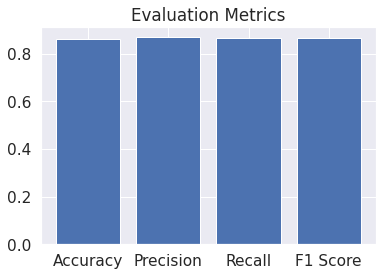

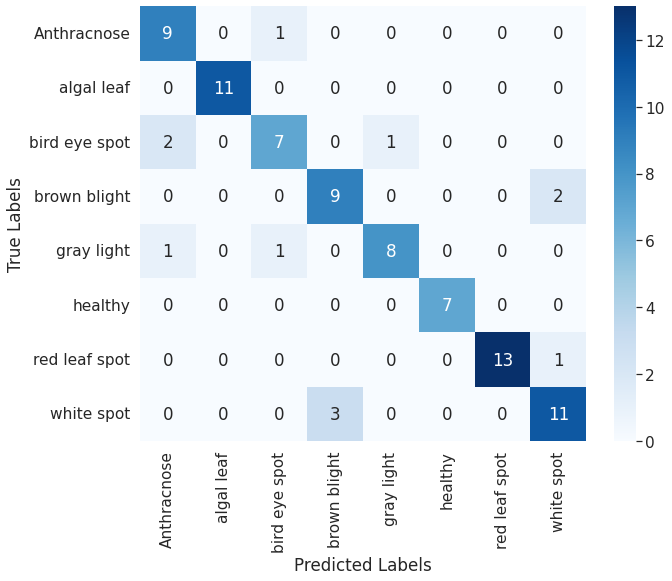

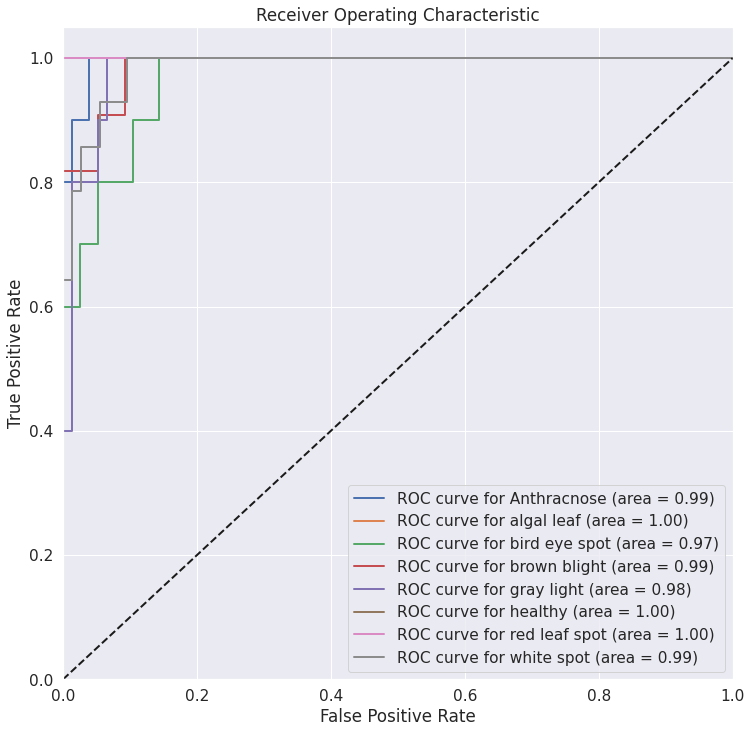

ROC Curve with class labels:
Anthracnose Anthracnose: 0.00
Anthracnose Anthracnose: 0.00
Anthracnose Anthracnose: 0.00
Anthracnose Anthracnose: 0.01
Anthracnose Anthracnose: 0.01
Anthracnose Anthracnose: 0.04
Anthracnose Anthracnose: 0.04
Anthracnose Anthracnose: 1.00
algal leaf Anthracnose: 0.00
algal leaf Anthracnose: 0.00
algal leaf Anthracnose: 0.00
algal leaf Anthracnose: 1.00
bird eye spot Anthracnose: 0.00
bird eye spot Anthracnose: 0.00
bird eye spot Anthracnose: 0.00
bird eye spot Anthracnose: 0.03
bird eye spot Anthracnose: 0.03
bird eye spot Anthracnose: 0.05
bird eye spot Anthracnose: 0.05
bird eye spot Anthracnose: 0.10
bird eye spot Anthracnose: 0.10
bird eye spot Anthracnose: 0.14
bird eye spot algal leaf: 0.14
bird eye spot algal leaf: 1.00
brown blight Anthracnose: 0.00
brown blight Anthracnose: 0.00
brown blight Anthracnose: 0.00
brown blight Anthracnose: 0.05
brown blight Anthracnose: 0.05
brown blight Anthracnose: 0.09
brown blight Anthracnose: 0.09
brown blight Ant

In [ ]:
#test performance of tea leaf net
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

class EnsembleGenerator(Sequence):
    def __init__(self, gen1, gen2, gen3):
        self.gen1 = gen1
        self.gen2 = gen2
        self.gen3 = gen3
        self.class_names = list(self.gen1.class_indices.keys())

    def __len__(self):
        return len(self.gen1)

    def __getitem__(self, idx):
        X1, y1 = self.gen1[idx]
        X2, y2 = self.gen2[idx]
        X3, y3 = self.gen3[idx]
        return [X1, X2, X3], y1  # or y2 or y3, since they should all have the same labels

test_generator = EnsembleGenerator(test_batches_googlenet, test_batches_vgg16, test_batches_resnet)



# load the trained model
model = keras.models.load_model('/content/drive/MyDrive/TeaLeafNet26Mar-8_update_resnet50login.h5')

# generate predictions for the test data
predictions = model.predict(test_generator)
y_pred=np.argmax(predictions, axis=1)

# Compute the evaluation metrics
y_true = test_generator.gen1.labels
print("y_true : ",y_true)
# calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
print("accuracy : ",accuracy)
precision = precision_score(y_true, y_pred, average='macro')
print("precision : ",precision)
recall = recall_score(y_true, y_pred, average='macro')
print("recall : ",recall)
f1 = f1_score(y_true, y_pred, average='macro')
print("f1 score : ",f1)
# plot evaluation metrics on a bar graph
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
metrics_values = [accuracy, precision, recall, f1]

plt.bar(metrics_names, metrics_values)
plt.title('Evaluation Metrics')
plt.show()




# get the actual class names
class_names = test_generator.class_names

# get the class indices from one of the original ImageDataGenerator objects
class_indices = test_batches_vgg16.class_indices

# create a dictionary that maps integer labels to actual class names
label_map = {v: k for k, v in class_indices.items()}

# convert the integer labels to actual class names
y_true_1 = [label_map[label] for label in y_true]
y_pred_1 = [label_map[label] for label in y_pred]

# calculate the confusion matrix
cm = confusion_matrix(y_true_1, y_pred_1)

# plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


class_names = test_generator.class_names
# Get the class indices from the test generator
class_indices = test_batches_vgg16.class_indices

# Invert the class indices to get the class labels with sequence
class_labels = dict((v, k) for k, v in class_indices.items())

# Map the integer labels to their corresponding class labels
y_true_labels = [class_labels[label] for label in y_true]
y_pred_labels = [class_labels[label] for label in y_pred]

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = model.output_shape[-1]

for j in range(n_classes):
    fpr[j], tpr[j], _ = roc_curve(y_true == j, predictions[:, j])
    roc_auc[j] = auc(fpr[j], tpr[j])

# Plot ROC curve
sns.set(font_scale=1.4)
plt.figure(figsize=(12, 12))
for j in range(n_classes):
    plt.plot(fpr[j], tpr[j], label='ROC curve for {} (area = {:.2f})'.format(class_labels[j], roc_auc[j]), linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Print ROC curve with class labels
print("ROC Curve with class labels:")
for j in range(n_classes):
    for i in range(len(fpr[j])):
        print("{} {}: {:.2f}".format(class_labels[j], y_true_labels[i], fpr[j][i]))

print(classification_report(y_true_labels, y_pred_labels))


In [ ]:
#Load and retrain
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

from keras.models import load_model

model = load_model('/content/drive/MyDrive/TeaLeafNetVgg16Login23Mar-5.h5')

error# Assuming your generator object is named "ensemble_generator" and your model object is named "model"
y_true = []
y_pred = []
for batch_idx in range(len(ensemble_test_generator)):
    _, batch_y_true = ensemble_test_generator[batch_idx]  # Get the true labels for the current batch
    batch_y_pred = model.predict_on_batch(ensemble_test_generator[batch_idx][0])  # Get the model's predictions for the current batch
    batch_y_pred = np.argmax(batch_y_pred, axis=1)
    y_true = np.argmax(y_true, axis=1).astype(int)

    y_true.append(y_true)  # Append the true labels for the current batch to the list of true labels
    y_pred.append(batch_y_pred)  # Append the model's predictions for the current batch to the list of predictions

# Convert the list of true labels and predictions to numpy arrays
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)


def evaluate_classification(y_true, y_pred):
    # Convert y_true to integer array
    y_true = y_true.astype(int)
    # Convert y_true to one-hot encoded format
    y_true = np.eye(y_pred.shape[1])[y_true]
    print("y pred : ",y_pred)
    print("y true : ", y_true)
    # Compute accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Compute precision, recall, and f1-score
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1-score:', f1)

    # Plot precision, recall, and f1-score on a bar graph
    metrics = ['Precision', 'Recall', 'F1-score']
    scores = [precision, recall, f1]
    plt.bar(metrics, scores)
    plt.title('Classification Metrics')
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.show()

    # Compute ROC curve and area under curve
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(y_pred.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr[0], tpr[0], color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc[0])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

evaluate_classification(y_true, y_pred)

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


AxisError: ignored

In [ ]:


import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.callbacks import LearningRateScheduler
from keras.metrics import categorical_crossentropy
from keras.layers import Activation
from keras.utils import get_custom_objects

import matplotlib.pyplot as plt
import os
import shutil
import random
import glob
import math
import tensorflow as tf
%matplotlib inline

from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import sklearn.metrics as metrics
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix


from tensorflow.keras.layers import Average, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.initializers import glorot_uniform


from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives +
    K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
train_path = '/content/drive/MyDrive/TeaDataSet/train'
valid_path = '/content/drive/MyDrive/TeaDataSet/valid'
test_path = '/content/drive/MyDrive/TeaDataSet/test'


get_custom_objects().update({'f1_m': f1_m,'precision_m':precision_m, 'recall_m':recall_m})



In [ ]:
train_batches_vgg16 = ImageDataGenerator( rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',preprocessing_function=tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(train_path, target_size=(224,224), batch_size=10)
valid_batches_vgg16 = ImageDataGenerator(rescale=1./255,preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(valid_path, target_size=(224,224), batch_size=10)
test_batches_vgg16 = ImageDataGenerator(rescale=1./255,preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(test_path, target_size=(224,224), batch_size=10,shuffle=False)


Found 706 images belonging to 8 classes.
Found 87 images belonging to 8 classes.
Found 87 images belonging to 8 classes.


In [ ]:
train_batches_googlenet = ImageDataGenerator( rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',preprocessing_function=tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(train_path, target_size=(224,224), batch_size=10)
valid_batches_googlenet = ImageDataGenerator(rescale=1./255,preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(valid_path, target_size=(224,224), batch_size=10)
test_batches_googlenet = ImageDataGenerator(rescale=1./255,preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(test_path, target_size=(224,224), batch_size=10,shuffle=False)


Found 706 images belonging to 8 classes.
Found 87 images belonging to 8 classes.
Found 87 images belonging to 8 classes.


In [ ]:
train_batches_resnet = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input).flow_from_directory(train_path, target_size=(224,224), batch_size=10)
valid_batches_resnet = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input).flow_from_directory(valid_path, target_size=(224,224), batch_size=10)
test_batches_resnet = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input).flow_from_directory(test_path, target_size=(224,224), batch_size=10,shuffle=False)


Found 706 images belonging to 8 classes.
Found 87 images belonging to 8 classes.
Found 87 images belonging to 8 classes.


In [ ]:
train_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input).flow_from_directory(train_path, target_size=(224,224), batch_size=10,class_mode='categorical')
val_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input).flow_from_directory(valid_path, target_size=(224,224), class_mode='categorical',batch_size=10)
test_batches_resnet = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input).flow_from_directory(test_path, target_size=(224,224), class_mode='categorical',batch_size=10,shuffle=False)


Found 706 images belonging to 8 classes.
Found 87 images belonging to 8 classes.
Found 87 images belonging to 8 classes.


In [ ]:
from keras.models import Model, load_model
from keras.layers import concatenate, Average, Dense, Input, multiply
from keras.optimizers import Adam
import numpy as np
import tensorflow as tf
from keras.utils import plot_model
from keras.layers import Flatten, Reshape
from keras.utils import Sequence


# Load the pre-trained models
googlenet = load_model('/content/drive/MyDrive/TeaLeafNet/googlenetmodel12mar2023.h5')
vgg16 = load_model('/content/drive/MyDrive/TeaLeafNet/vgg16TeaLeaf.h5')
resnet50 = load_model('/content/drive/MyDrive/TeaLeafNet/resnet50Mar092023.h5')

# Rename the common layers in each model
for layer in googlenet.layers:
    layer._name = 'googlenet_' + layer.name
for layer in vgg16.layers:
    layer._name = 'vgg16_' + layer.name
for layer in resnet50.layers:
    layer._name = 'resnet50_' + layer.name

# Freeze the layers
for layer in googlenet.layers[:-1]:
    layer.trainable = False
for layer in vgg16.layers[:-1]:
    layer.trainable = False
for layer in resnet50.layers[:-1]:
    layer.trainable = False

# Define the weightage scheme based on the test accuracies of the models
googlenet_weight = 0.5
vgg16_weight = 0.3
resnet50_weight = 0.2

#resnet50.summary()
#plot_model(resnet50,show_shapes=True)

# Create a new model that combines the outputs of the pre-trained models

googlenet_output = Flatten()(googlenet.get_layer('googlenet_avg_pool_5_3x3/1').output)
print("googlenet_output.shape",googlenet_output.shape)
vgg16_output = Flatten()(vgg16.get_layer('vgg16_block5_pool').output)
print("vgg16_output.shape",vgg16_output.shape)

resnet50_output = Flatten()(resnet50.get_layer('resnet50_average_pooling2d_6').output)
print("resnet50_output.shape",resnet50_output.shape)


merged_output = concatenate([googlenet_output, vgg16_output, resnet50_output])
print("merged_output",merged_output)
output_tensor = Dense(8, activation='softmax')(merged_output)

print("googlenet input ",googlenet.input)
print("vgg16 input ",vgg16.input)
print("resnet50 input ",resnet50.input)


ensemble_model = Model(inputs=[googlenet.input, vgg16.input, resnet50.input], outputs=output_tensor)

# Train the new model
epochs = 100
initial_lrate = 0.001
def decay(epoch, steps=100):
  initial_lrate = 0.01
  drop = 0.96
  epochs_drop = 8
  lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  return lrate
sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)
lr_sc = LearningRateScheduler(decay, verbose=1)

ensemble_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

callback_list=[EarlyStopping(monitor="val_loss",patience=250),ModelCheckpoint(filepath="/content/drive/MyDrive/TeaLeafNetV1.0.h5",monitor="val_loss",save_best_only=True,verbose=1)]


class EnsembleGenerator(Sequence):
    def __init__(self, gen1, gen2, gen3):
        self.gen1 = gen1
        self.gen2 = gen2
        self.gen3 = gen3

    def __len__(self):
        return len(self.gen1)

    def __getitem__(self, idx):
        X1, y1 = self.gen1[idx]
        X2, y2 = self.gen2[idx]
        X3, y3 = self.gen3[idx]
        return [X1, X2, X3], y1  # or y2 or y3, since they should all have the same labels

ensemble_train_generator = EnsembleGenerator(train_batches_googlenet, train_batches_vgg16, train_batches_resnet)

ensemble_model.fit_generator(ensemble_train_generator,

                              epochs=1000,
                              validation_data=val_generator,
                              callbacks=callback_list)



googlenet_output.shape (None, 1024)
vgg16_output.shape (None, 25088)
resnet50_output.shape (None, 32768)
merged_output KerasTensor(type_spec=TensorSpec(shape=(None, 58880), dtype=tf.float32, name=None), name='concatenate_60/concat:0', description="created by layer 'concatenate_60'")
googlenet input  KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='googlenetInput'), name='googlenetInput', description="created by layer 'googlenet_googlenetInput'")
vgg16 input  KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
resnet50 input  KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_7'), name='input_7', description="created by layer 'resnet50_input_7'")


ValueError: ignored

In [ ]:
import keras.backend as K

# create a tensor
tensor = K.variable([[1, 2, 3], [4, 5, 6]])

# create a constant tensor with value 0.5
constant_tensor = K.constant(0.5)

# multiply the tensor with the constant tensor element-wise
result = K.dot(tensor, constant_tensor)

# print the result
print(result)


InvalidArgumentError: ignored


weighted_vgg16_output = multiply([vgg16_output, tf.constant(vgg16_weight, shape=(1, 1, 1, 8))])
weighted_resnet50_output = multiply([resnet50_output, tf.constant(resnet50_weight, shape=(1, 1, 1, 8))])

# Combine the weighted model outputs
merged_model_output = concatenate([weighted_googlenet_output, weighted_vgg16_output, weighted_resnet50_output])


output_tensor = Dense(8, activation='softmax')(merged_model_output)
ensemble_model = Model(inputs=[googlenet.input, vgg16.input, resnet50.input], outputs=output_tensor)




# Train the new model
epochs = 100
initial_lrate = 0.001
def decay(epoch, steps=100):
  initial_lrate = 0.01
  drop = 0.96
  epochs_drop = 8
  lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  return lrate
sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)
lr_sc = LearningRateScheduler(decay, verbose=1)

ensemble_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

callback_list=[EarlyStopping(monitor="val_loss",patience=150),ModelCheckpoint(filepath="/content/drive/MyDrive/TeaLeafNet12Mar2023.h5",monitor="val_loss",save_best_only=True,verbose=1)]

ensemble_model.fit(
    [train_batches_googlenet, train_batches_vgg16, train_batches_resnet],
    steps_per_epoch=len(train_generator_1),
    epochs=100,
    validation_data=([valid_batches_googlenet, valid_batches_vgg16, valid_batches_resnet]),
    validation_steps=len(val_generator_1),
    callbacks=callback_list
)
